# CatBoost Regressor

Este notebook implementa un modelo de CatBoost Regressor para predecir la popularidad de canciones.

## Objetivo
Implementar y evaluar un modelo de CatBoost Regressor, comparando su desempeño con Random Forest y otros modelos.

## ¿Qué es CatBoost?
CatBoost (Categorical Boosting) es un algoritmo de gradient boosting desarrollado por Yandex que destaca por:
- ✅ Excelente manejo de variables categóricas (nativo)
- ✅ Resistente al overfitting (ordered boosting)
- ✅ Hiperparámetros por defecto muy buenos
- ✅ Rápido entrenamiento con GPU
- ✅ Suele superar a Random Forest y otros algoritmos

## Instalación
Si es la primera vez que ejecutas este notebook, necesitas instalar CatBoost.


In [ ]:
# Instalación de CatBoost (ejecutar solo la primera vez)
# Descomenta la siguiente línea si no tienes CatBoost instalado:
# !pip install catboost

print("Si CatBoost no está instalado, descomenta la línea de arriba y ejecuta esta celda.")


In [2]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# CatBoost
from catboost import CatBoostRegressor, Pool

# Optuna para optimización de hiperparámetros
try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print("✅ Optuna disponible para optimización bayesiana")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠️  Optuna no disponible. Instala con: pip install optuna")

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")


✅ Optuna disponible para optimización bayesiana
✅ Librerías importadas correctamente


c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Carga de Datos

Cargamos los datos con feature engineering aplicado.


In [3]:
# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datos con feature engineering
train_path = DATA / "train_fe.csv"
test_path = DATA / "test_fe.csv"

assert train_path.exists(), f"No se encontró {train_path}"
assert test_path.exists(), f"No se encontró {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas disponibles:")
print(train.columns.tolist())


✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 17)

Columnas disponibles:
['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2. Preparación de Datos

Separamos las características (X) de la variable objetivo (y) y eliminamos columnas no relevantes.


In [4]:
# Variable objetivo
target_col = "popularity"

# Separar características y variable objetivo
X_train_full = train.drop(columns=[target_col, "track_id"])  # Eliminar track_id (identificador)
y_train_full = train[target_col]

# Preparar test (sin track_id)
X_test = test.drop(columns=["track_id"], errors="ignore")

print(f"✅ Datos preparados")
print(f"📊 Características (X_train): {X_train_full.shape}")
print(f"📊 Variable objetivo (y_train): {y_train_full.shape}")
print(f"\nCaracterísticas a utilizar:")
print(X_train_full.columns.tolist())


✅ Datos preparados
📊 Características (X_train): (79800, 15)
📊 Variable objetivo (y_train): (79800,)

Características a utilizar:
['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 3. División Train/Validation

Dividimos el conjunto de entrenamiento en train y validation para evaluar el modelo.


In [5]:
# División train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"✅ División completada")
print(f"📊 Train: {X_train.shape[0]} muestras")
print(f"📊 Validation: {X_val.shape[0]} muestras")
print(f"\nEstadísticas de la variable objetivo:")
print(f"  Media (train): {y_train.mean():.2f}")
print(f"  Media (validation): {y_val.mean():.2f}")
print(f"  Desviación estándar (train): {y_train.std():.2f}")
print(f"  Desviación estándar (validation): {y_val.std():.2f}")


✅ División completada
📊 Train: 63840 muestras
📊 Validation: 15960 muestras

Estadísticas de la variable objetivo:
  Media (train): 33.32
  Media (validation): 33.03
  Desviación estándar (train): 22.35
  Desviación estándar (validation): 22.24


## 4. Entrenamiento del Modelo Base

Entrenamos el modelo de CatBoost Regressor con hiperparámetros por defecto.

**Ventajas de CatBoost:**
- No requiere escalado de características
- Manejo automático de overfitting con early stopping
- Hiperparámetros por defecto ya son muy buenos
- Más rápido que otros gradient boosting con mismo rendimiento


In [6]:
# Crear modelo CatBoost con hiperparámetros por defecto
modelo_catboost = CatBoostRegressor(
    iterations=1000,          # Número de árboles
    learning_rate=0.1,        # Tasa de aprendizaje
    depth=6,                  # Profundidad de los árboles
    loss_function='RMSE',     # Función de pérdida
    random_state=42,
    verbose=100               # Mostrar progreso cada 100 iteraciones
)

print("🔄 Entrenando modelo de CatBoost Regressor...")
print("⏳ Esto puede tomar algunos minutos...")
print("💡 CatBoost usa early stopping automático para prevenir overfitting\n")

# Entrenar con early stopping
modelo_catboost.fit(
    X_train, 
    y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,  # Detener si no mejora en 50 iteraciones
    verbose=False
)

print(f"\n✅ Modelo entrenado correctamente")
print(f"📊 Número de iteraciones: {modelo_catboost.get_best_iteration()}")
print(f"📊 Score en train: {modelo_catboost.score(X_train, y_train):.4f}")
print(f"📊 Score en validation: {modelo_catboost.score(X_val, y_val):.4f}")

# Importancia de características
importancias = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': modelo_catboost.feature_importances_
}).sort_values('Importancia', ascending=False)

print(f"\nTop 10 características más importantes:")
print(importancias.head(10).to_string(index=False))


🔄 Entrenando modelo de CatBoost Regressor...
⏳ Esto puede tomar algunos minutos...
💡 CatBoost usa early stopping automático para prevenir overfitting


✅ Modelo entrenado correctamente
📊 Número de iteraciones: 997
📊 Score en train: 0.9433
📊 Score en validation: 0.9281

Top 10 características más importantes:
       Característica  Importancia
album_mean_popularity    70.199492
genre_mean_popularity    15.660617
         artist_count     4.771656
     instrumentalness     2.018917
         danceability     1.327455
             loudness     1.311507
               energy     1.037649
              valence     0.977767
       track_name_len     0.788047
                tempo     0.760193


## 5. Predicciones

Realizamos predicciones en los conjuntos de train y validation.


In [7]:
# Predicciones
y_train_pred = modelo_catboost.predict(X_train)
y_val_pred = modelo_catboost.predict(X_val)

# Aplicar clipping al rango válido [0, 100]
y_train_pred_clipped = np.clip(y_train_pred, 0, 100)
y_val_pred_clipped = np.clip(y_val_pred, 0, 100)

print("✅ Predicciones generadas")
print(f"\n📊 Estadísticas de predicciones (validation):")
print(f"  Mínimo: {y_val_pred_clipped.min():.2f}")
print(f"  Máximo: {y_val_pred_clipped.max():.2f}")
print(f"  Media: {y_val_pred_clipped.mean():.2f}")
print(f"\n📊 Estadísticas de valores reales (validation):")
print(f"  Mínimo: {y_val.min():.2f}")
print(f"  Máximo: {y_val.max():.2f}")
print(f"  Media: {y_val.mean():.2f}")


✅ Predicciones generadas

📊 Estadísticas de predicciones (validation):
  Mínimo: 0.00
  Máximo: 91.20
  Media: 33.14

📊 Estadísticas de valores reales (validation):
  Mínimo: 0.00
  Máximo: 98.00
  Media: 33.03


## 6. Evaluación del Modelo

Calculamos métricas de evaluación: RMSE, MAE y R².


In [8]:
# Función para calcular métricas
def evaluar_modelo(y_real, y_pred, conjunto="Conjunto"):
    """Calcula y muestra métricas de evaluación"""
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    print(f"\n📈 Métricas de evaluación - {conjunto}:")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² (Coeficiente de determinación): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluar en train y validation
metricas_train = evaluar_modelo(y_train, y_train_pred_clipped, "Train")
metricas_val = evaluar_modelo(y_val, y_val_pred_clipped, "Validation")

# Resumen comparativo
resumen = pd.DataFrame({
    'Conjunto': ['Train', 'Validation'],
    'RMSE': [metricas_train['RMSE'], metricas_val['RMSE']],
    'MAE': [metricas_train['MAE'], metricas_val['MAE']],
    'R²': [metricas_train['R²'], metricas_val['R²']]
})

print("\n" + "=" * 60)
print("📊 RESUMEN DE DESEMPEÑO - CATBOOST REGRESSOR")
print("=" * 60)
print(resumen.to_string(index=False))
print("=" * 60)

# Análisis de generalización
diferencia_rmse = abs(metricas_train['RMSE'] - metricas_val['RMSE'])
diferencia_r2 = abs(metricas_train['R²'] - metricas_val['R²'])

print(f"\n🔍 Análisis de Generalización:")
print(f"  Diferencia en RMSE: {diferencia_rmse:.4f}")
print(f"  Diferencia en R²: {diferencia_r2:.4f}")

if diferencia_r2 < 0.05:
    print("  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)")
elif diferencia_r2 < 0.10:
    print("  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)")
else:
    print("  ⚠️  Posible sobreajuste significativo (diferencia grande entre train y validation)")



📈 Métricas de evaluación - Train:
  RMSE (Root Mean Squared Error): 5.3219
  MAE (Mean Absolute Error): 3.2784
  R² (Coeficiente de determinación): 0.9433

📈 Métricas de evaluación - Validation:
  RMSE (Root Mean Squared Error): 5.9592
  MAE (Mean Absolute Error): 3.5835
  R² (Coeficiente de determinación): 0.9282

📊 RESUMEN DE DESEMPEÑO - CATBOOST REGRESSOR
  Conjunto     RMSE      MAE       R²
     Train 5.321934 3.278351 0.943321
Validation 5.959188 3.583534 0.928174

🔍 Análisis de Generalización:
  Diferencia en RMSE: 0.6373
  Diferencia en R²: 0.0151
  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)


## 7. Visualizaciones

Visualizamos los resultados del modelo.


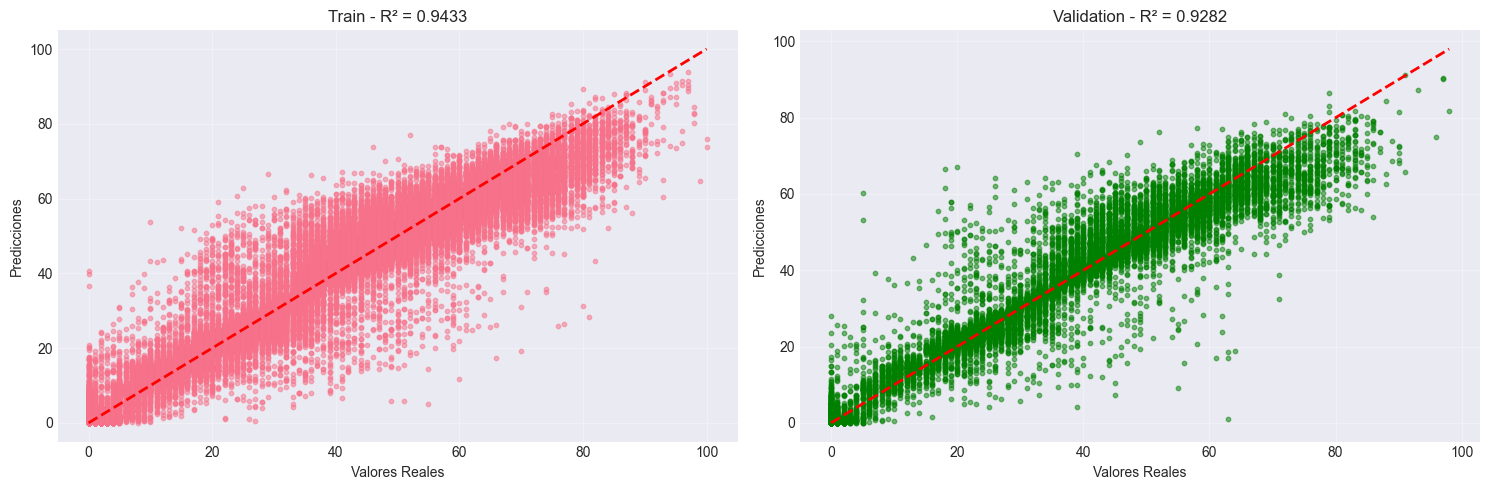

In [9]:
# Visualización 1: Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train, y_train_pred_clipped, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Train - R² = {metricas_train["R²"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred_clipped, alpha=0.5, s=10, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title(f'Validation - R² = {metricas_val["R²"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


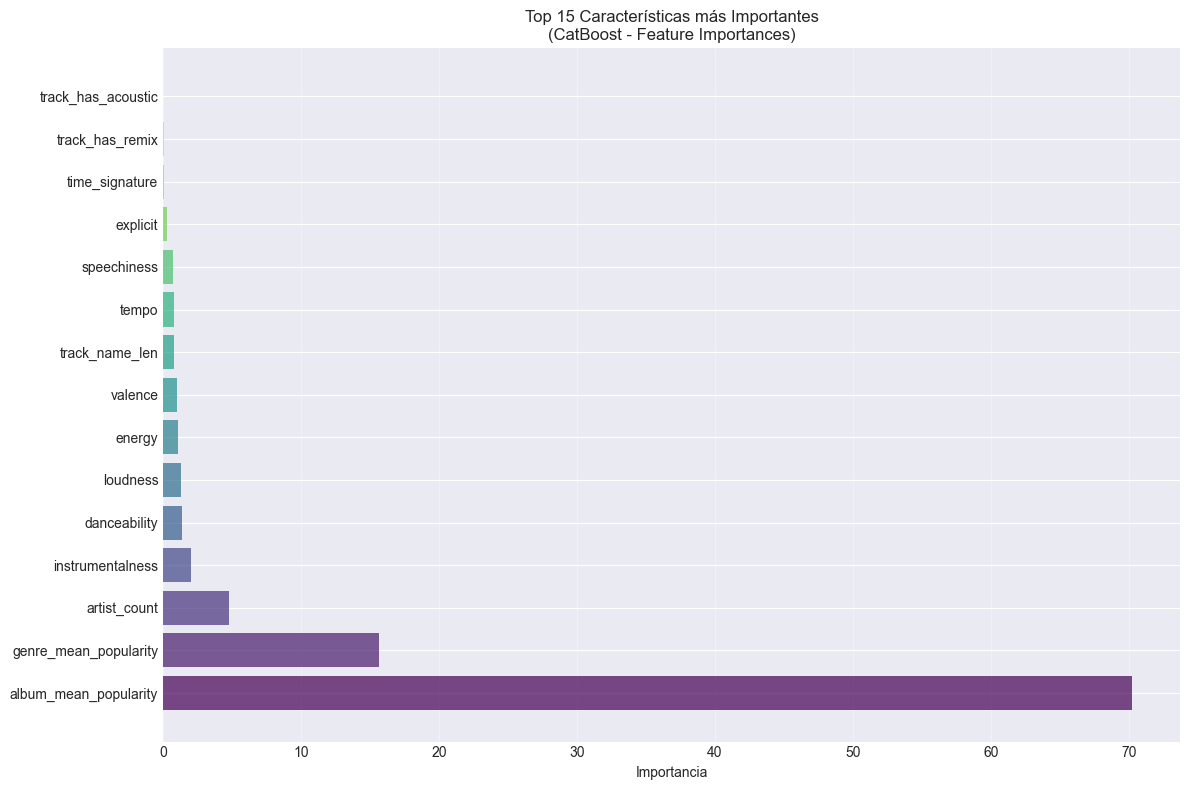

In [10]:
# Visualización 2: Importancia de características
plt.figure(figsize=(12, 8))
importancias_plot = importancias.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(importancias_plot)))
plt.barh(range(len(importancias_plot)), importancias_plot['Importancia'], color=colors, alpha=0.7)
plt.yticks(range(len(importancias_plot)), importancias_plot['Característica'])
plt.xlabel('Importancia')
plt.title('Top 15 Características más Importantes\n(CatBoost - Feature Importances)')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 8. Optimización de Hiperparámetros con Optuna

Utilizamos Optuna para encontrar los mejores hiperparámetros de CatBoost mediante optimización bayesiana.


In [11]:
# Configuración de Cross-Validation
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Scorer personalizado para RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), 
                          greater_is_better=False)

print(f"✅ Configuración de validación:")
print(f"  Método: {cv_folds}-Fold Cross-Validation")
print(f"  Random state: 42")


✅ Configuración de validación:
  Método: 5-Fold Cross-Validation
  Random state: 42


In [12]:
# Optimización de hiperparámetros con Optuna para CatBoost
if OPTUNA_AVAILABLE:
    print("=" * 70)
    print("🔄 Búsqueda de Hiperparámetros con Optuna - CatBoost")
    print("=" * 70)
    print("⏳ Optuna utilizará optimización bayesiana para encontrar los mejores hiperparámetros")
    print("⏳ Esto puede tomar varios minutos...")
    
    def objective_catboost(trial):
        """Función objetivo que Optuna optimizará para CatBoost"""
        params = {
            'iterations': trial.suggest_int('iterations', 500, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_state': 42,
            'verbose': False
        }
        
        # Crear y evaluar modelo con estos hiperparámetros
        model = CatBoostRegressor(**params)
        
        # Usar cross-validation para evaluar
        scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=kfold, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1
        )
        
        # Retornar el score medio (negativo porque queremos maximizar)
        return scores.mean()
    
    # Crear estudio de Optuna
    study = optuna.create_study(
        direction='maximize',
        study_name='catboost_optimization',
        sampler=TPESampler(seed=42)
    )
    
    # Optimizar (50 trials)
    n_trials = 50
    print(f"\n🔍 Ejecutando {n_trials} trials de optimización...")
    study.optimize(objective_catboost, n_trials=n_trials, show_progress_bar=True)
    
    print("\n✅ Optimización completada")
    print(f"\n📊 Mejor configuración encontrada por Optuna:")
    print(f"  Número de trials: {len(study.trials)}")
    print(f"  Mejor score (neg MSE): {study.best_value:.4f}")
    print(f"  Mejor RMSE estimado: {np.sqrt(-study.best_value):.4f}")
    print(f"\n  Mejores hiperparámetros:")
    for param, value in study.best_params.items():
        print(f"    {param}: {value}")
    
    # Guardar mejores hiperparámetros
    optuna_best_params_catboost = study.best_params.copy()
    optuna_best_params_catboost['random_state'] = 42
    optuna_best_params_catboost['verbose'] = False
    
else:
    print("⚠️  Optuna no está disponible. Instala con: pip install optuna")
    optuna_best_params_catboost = None
    study = None


[I 2025-12-09 19:55:00,516] A new study created in memory with name: catboost_optimization


🔄 Búsqueda de Hiperparámetros con Optuna - CatBoost
⏳ Optuna utilizará optimización bayesiana para encontrar los mejores hiperparámetros
⏳ Esto puede tomar varios minutos...

🔍 Ejecutando 50 trials de optimización...


Best trial: 0. Best value: -38.5585:   2%|▏         | 1/50 [00:26<21:59, 26.92s/it]

[I 2025-12-09 19:55:27,438] Trial 0 finished with value: -38.558530403835995 and parameters: {'iterations': 1000, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'bagging_temperature': 0.15601864044243652, 'border_count': 66}. Best is trial 0 with value: -38.558530403835995.


Best trial: 1. Best value: -34.7973:   4%|▍         | 2/50 [00:43<16:33, 20.69s/it]

[I 2025-12-09 19:55:43,762] Trial 1 finished with value: -34.79727364492862 and parameters: {'iterations': 500, 'learning_rate': 0.19030368381735815, 'depth': 8, 'l2_leaf_reg': 7.372653200164409, 'bagging_temperature': 0.020584494295802447, 'border_count': 249}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:   6%|▌         | 3/50 [01:09<18:19, 23.40s/it]

[I 2025-12-09 19:56:10,398] Trial 2 finished with value: -42.494067376288285 and parameters: {'iterations': 1800, 'learning_rate': 0.020589728197687916, 'depth': 5, 'l2_leaf_reg': 2.650640588680904, 'bagging_temperature': 0.3042422429595377, 'border_count': 149}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:   8%|▊         | 4/50 [01:33<17:54, 23.36s/it]

[I 2025-12-09 19:56:33,696] Trial 3 finished with value: -40.194761632959 and parameters: {'iterations': 1100, 'learning_rate': 0.02692655251486473, 'depth': 8, 'l2_leaf_reg': 2.2554447458683766, 'bagging_temperature': 0.29214464853521815, 'border_count': 114}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  10%|█         | 5/50 [01:49<15:29, 20.64s/it]

[I 2025-12-09 19:56:49,523] Trial 4 finished with value: -41.554393552417025 and parameters: {'iterations': 1200, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 5.628109945722504, 'bagging_temperature': 0.5924145688620425, 'border_count': 42}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  12%|█▏        | 6/50 [02:04<13:58, 19.06s/it]

[I 2025-12-09 19:57:05,504] Trial 5 finished with value: -46.51575845646191 and parameters: {'iterations': 1400, 'learning_rate': 0.0178601378893971, 'depth': 4, 'l2_leaf_reg': 9.539969835279999, 'bagging_temperature': 0.9656320330745594, 'border_count': 213}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  14%|█▍        | 7/50 [02:26<14:09, 19.76s/it]

[I 2025-12-09 19:57:26,694] Trial 6 finished with value: -44.98713601832644 and parameters: {'iterations': 900, 'learning_rate': 0.013940346079873234, 'depth': 8, 'l2_leaf_reg': 4.961372443656412, 'bagging_temperature': 0.12203823484477883, 'border_count': 142}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  16%|█▌        | 8/50 [02:32<10:56, 15.62s/it]

[I 2025-12-09 19:57:33,462] Trial 7 finished with value: -38.345595623988174 and parameters: {'iterations': 500, 'learning_rate': 0.22038218939289875, 'depth': 5, 'l2_leaf_reg': 6.962700559185838, 'bagging_temperature': 0.31171107608941095, 'border_count': 148}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  18%|█▊        | 9/50 [04:19<30:00, 43.91s/it]

[I 2025-12-09 19:59:19,568] Trial 8 finished with value: -39.450697960029174 and parameters: {'iterations': 1300, 'learning_rate': 0.01875220945578641, 'depth': 10, 'l2_leaf_reg': 7.976195410250031, 'bagging_temperature': 0.9394989415641891, 'border_count': 232}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  20%|██        | 10/50 [04:34<23:26, 35.15s/it]

[I 2025-12-09 19:59:35,125] Trial 9 finished with value: -38.518750425477684 and parameters: {'iterations': 1400, 'learning_rate': 0.22999586428143728, 'depth': 4, 'l2_leaf_reg': 2.763845761772307, 'bagging_temperature': 0.045227288910538066, 'border_count': 104}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  22%|██▏       | 11/50 [04:44<17:53, 27.52s/it]

[I 2025-12-09 19:59:45,333] Trial 10 finished with value: -40.18738286433942 and parameters: {'iterations': 500, 'learning_rate': 0.07233285565832946, 'depth': 7, 'l2_leaf_reg': 9.393649409516417, 'bagging_temperature': 0.6400885024675561, 'border_count': 196}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  24%|██▍       | 12/50 [04:54<14:05, 22.24s/it]

[I 2025-12-09 19:59:55,492] Trial 11 finished with value: -39.7014766633694 and parameters: {'iterations': 500, 'learning_rate': 0.10149943433079933, 'depth': 6, 'l2_leaf_reg': 7.448662161563269, 'bagging_temperature': 0.39305892765510636, 'border_count': 188}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  26%|██▌       | 13/50 [05:09<12:13, 19.83s/it]

[I 2025-12-09 20:00:09,790] Trial 12 finished with value: -40.00958099808592 and parameters: {'iterations': 700, 'learning_rate': 0.043812383564303524, 'depth': 7, 'l2_leaf_reg': 4.548711040907931, 'bagging_temperature': 0.0069875217952386545, 'border_count': 254}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  28%|██▊       | 14/50 [05:22<10:42, 17.83s/it]

[I 2025-12-09 20:00:23,006] Trial 13 finished with value: -36.6569820599079 and parameters: {'iterations': 800, 'learning_rate': 0.1661795822732959, 'depth': 6, 'l2_leaf_reg': 7.659563553460653, 'bagging_temperature': 0.4687052188878422, 'border_count': 163}. Best is trial 1 with value: -34.79727364492862.


Best trial: 1. Best value: -34.7973:  30%|███       | 15/50 [05:43<10:54, 18.69s/it]

[I 2025-12-09 20:00:43,693] Trial 14 finished with value: -35.87909438352531 and parameters: {'iterations': 800, 'learning_rate': 0.12959963010175102, 'depth': 8, 'l2_leaf_reg': 8.176035804287608, 'bagging_temperature': 0.7242764029969626, 'border_count': 179}. Best is trial 1 with value: -34.79727364492862.


Best trial: 15. Best value: -34.7762:  32%|███▏      | 16/50 [06:13<12:33, 22.17s/it]

[I 2025-12-09 20:01:13,940] Trial 15 finished with value: -34.77624843075738 and parameters: {'iterations': 700, 'learning_rate': 0.1057130343116806, 'depth': 9, 'l2_leaf_reg': 8.620486644720243, 'bagging_temperature': 0.7979948690790168, 'border_count': 255}. Best is trial 15 with value: -34.77624843075738.


Best trial: 16. Best value: -33.468:  34%|███▍      | 17/50 [08:26<30:29, 55.45s/it] 

[I 2025-12-09 20:03:26,776] Trial 16 finished with value: -33.468044472406504 and parameters: {'iterations': 1700, 'learning_rate': 0.06196071286073588, 'depth': 10, 'l2_leaf_reg': 8.774478329323099, 'bagging_temperature': 0.7859952098189739, 'border_count': 250}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  36%|███▌      | 18/50 [10:44<42:48, 80.26s/it]

[I 2025-12-09 20:05:44,791] Trial 17 finished with value: -34.52077580054165 and parameters: {'iterations': 2000, 'learning_rate': 0.04910118882316495, 'depth': 10, 'l2_leaf_reg': 9.868435494569692, 'bagging_temperature': 0.8163160113105377, 'border_count': 215}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  38%|███▊      | 19/50 [12:59<49:59, 96.77s/it]

[I 2025-12-09 20:08:00,035] Trial 18 finished with value: -34.86593164101571 and parameters: {'iterations': 2000, 'learning_rate': 0.04326154516755918, 'depth': 10, 'l2_leaf_reg': 9.83477982775857, 'bagging_temperature': 0.8367378436988993, 'border_count': 216}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  40%|████      | 20/50 [15:26<55:59, 111.98s/it]

[I 2025-12-09 20:10:27,446] Trial 19 finished with value: -33.989422005928255 and parameters: {'iterations': 1700, 'learning_rate': 0.06836701093453884, 'depth': 10, 'l2_leaf_reg': 8.890289132890816, 'bagging_temperature': 0.8405371917283118, 'border_count': 224}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  42%|████▏     | 21/50 [16:19<45:33, 94.24s/it] 

[I 2025-12-09 20:11:20,350] Trial 20 finished with value: -33.56922682361339 and parameters: {'iterations': 1600, 'learning_rate': 0.06708424404277645, 'depth': 9, 'l2_leaf_reg': 3.6230595247441872, 'bagging_temperature': 0.6089582803996043, 'border_count': 240}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  44%|████▍     | 22/50 [17:17<38:54, 83.37s/it]

[I 2025-12-09 20:12:18,374] Trial 21 finished with value: -33.64779113694003 and parameters: {'iterations': 1600, 'learning_rate': 0.07116651699282554, 'depth': 9, 'l2_leaf_reg': 3.700429317007825, 'bagging_temperature': 0.6862264445300784, 'border_count': 232}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  46%|████▌     | 23/50 [18:13<33:43, 74.95s/it]

[I 2025-12-09 20:13:13,675] Trial 22 finished with value: -35.558097201961345 and parameters: {'iterations': 1600, 'learning_rate': 0.030979015428443033, 'depth': 9, 'l2_leaf_reg': 1.0560872409071536, 'bagging_temperature': 0.6041585495011991, 'border_count': 238}. Best is trial 16 with value: -33.468044472406504.


Best trial: 16. Best value: -33.468:  48%|████▊     | 24/50 [19:05<29:34, 68.23s/it]

[I 2025-12-09 20:14:06,243] Trial 23 finished with value: -34.49070652910507 and parameters: {'iterations': 1600, 'learning_rate': 0.06763261196184177, 'depth': 9, 'l2_leaf_reg': 3.982980384860257, 'bagging_temperature': 0.7018678985504766, 'border_count': 200}. Best is trial 16 with value: -33.468044472406504.


Best trial: 24. Best value: -33.1403:  50%|█████     | 25/50 [20:07<27:37, 66.29s/it]

[I 2025-12-09 20:15:07,989] Trial 24 finished with value: -33.14028873077326 and parameters: {'iterations': 1800, 'learning_rate': 0.09011931650322565, 'depth': 9, 'l2_leaf_reg': 3.76001620514291, 'bagging_temperature': 0.5218016745552432, 'border_count': 233}. Best is trial 24 with value: -33.14028873077326.


Best trial: 24. Best value: -33.1403:  52%|█████▏    | 26/50 [21:45<30:16, 75.68s/it]

[I 2025-12-09 20:16:45,583] Trial 25 finished with value: -34.15640903962522 and parameters: {'iterations': 1800, 'learning_rate': 0.09544459863019326, 'depth': 10, 'l2_leaf_reg': 3.4474709126237775, 'bagging_temperature': 0.5173525652140669, 'border_count': 176}. Best is trial 24 with value: -33.14028873077326.


Best trial: 24. Best value: -33.1403:  54%|█████▍    | 27/50 [22:35<26:07, 68.16s/it]

[I 2025-12-09 20:17:36,199] Trial 26 finished with value: -35.990571105960186 and parameters: {'iterations': 1900, 'learning_rate': 0.034312111441879026, 'depth': 9, 'l2_leaf_reg': 6.003270118091541, 'bagging_temperature': 0.522489108868915, 'border_count': 203}. Best is trial 24 with value: -33.14028873077326.


Best trial: 24. Best value: -33.1403:  56%|█████▌    | 28/50 [23:05<20:47, 56.73s/it]

[I 2025-12-09 20:18:06,249] Trial 27 finished with value: -34.256959585384074 and parameters: {'iterations': 1500, 'learning_rate': 0.05631927957499791, 'depth': 8, 'l2_leaf_reg': 1.5952548489201415, 'bagging_temperature': 0.457417335034527, 'border_count': 244}. Best is trial 24 with value: -33.14028873077326.


Best trial: 28. Best value: -33.0333:  58%|█████▊    | 29/50 [29:14<52:38, 150.40s/it]

[I 2025-12-09 20:24:15,197] Trial 28 finished with value: -33.03332055505539 and parameters: {'iterations': 1800, 'learning_rate': 0.11084594499932923, 'depth': 10, 'l2_leaf_reg': 4.870216374313456, 'bagging_temperature': 0.7655258729494452, 'border_count': 233}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  60%|██████    | 30/50 [30:22<41:52, 125.62s/it]

[I 2025-12-09 20:25:23,005] Trial 29 finished with value: -38.201652070690606 and parameters: {'iterations': 1800, 'learning_rate': 0.2974293928652365, 'depth': 10, 'l2_leaf_reg': 6.391218451505819, 'bagging_temperature': 0.9011493027457239, 'border_count': 93}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  62%|██████▏   | 31/50 [33:37<46:21, 146.38s/it]

[I 2025-12-09 20:28:37,839] Trial 30 finished with value: -33.118406651919884 and parameters: {'iterations': 1900, 'learning_rate': 0.08812065063292726, 'depth': 10, 'l2_leaf_reg': 4.731325809354438, 'bagging_temperature': 0.7573147661433607, 'border_count': 224}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  64%|██████▍   | 32/50 [36:57<48:45, 162.54s/it]

[I 2025-12-09 20:31:58,090] Trial 31 finished with value: -33.13482601526885 and parameters: {'iterations': 1900, 'learning_rate': 0.09026268439241496, 'depth': 10, 'l2_leaf_reg': 4.92644822384808, 'bagging_temperature': 0.7543777545240531, 'border_count': 225}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  66%|██████▌   | 33/50 [39:13<43:49, 154.68s/it]

[I 2025-12-09 20:34:14,420] Trial 32 finished with value: -33.317007674347956 and parameters: {'iterations': 1900, 'learning_rate': 0.08865594557985877, 'depth': 10, 'l2_leaf_reg': 4.965828166116973, 'bagging_temperature': 0.7504501309706668, 'border_count': 223}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  68%|██████▊   | 34/50 [41:24<39:20, 147.53s/it]

[I 2025-12-09 20:36:25,259] Trial 33 finished with value: -33.628660027251115 and parameters: {'iterations': 1900, 'learning_rate': 0.11824797781419755, 'depth': 10, 'l2_leaf_reg': 4.293536824723255, 'bagging_temperature': 0.8819375343884701, 'border_count': 214}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  70%|███████   | 35/50 [42:29<30:39, 122.63s/it]

[I 2025-12-09 20:37:29,783] Trial 34 finished with value: -34.092671183356906 and parameters: {'iterations': 2000, 'learning_rate': 0.0855973376293386, 'depth': 9, 'l2_leaf_reg': 5.091857774167385, 'bagging_temperature': 0.6651746294259464, 'border_count': 187}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  72%|███████▏  | 36/50 [43:59<26:22, 113.00s/it]

[I 2025-12-09 20:39:00,331] Trial 35 finished with value: -34.855809071921 and parameters: {'iterations': 1700, 'learning_rate': 0.1564638698837629, 'depth': 10, 'l2_leaf_reg': 3.0332206902953334, 'bagging_temperature': 0.5599341130309774, 'border_count': 132}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  74%|███████▍  | 37/50 [44:54<20:40, 95.39s/it] 

[I 2025-12-09 20:39:54,631] Trial 36 finished with value: -34.48788711099856 and parameters: {'iterations': 1800, 'learning_rate': 0.1857118248217528, 'depth': 9, 'l2_leaf_reg': 5.631479695897937, 'bagging_temperature': 0.9877539799326079, 'border_count': 168}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  76%|███████▌  | 38/50 [45:27<15:21, 76.76s/it]

[I 2025-12-09 20:40:27,922] Trial 37 finished with value: -37.201211506286825 and parameters: {'iterations': 1900, 'learning_rate': 0.13603344984076776, 'depth': 8, 'l2_leaf_reg': 6.489800509748359, 'bagging_temperature': 0.22915471337745846, 'border_count': 71}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  78%|███████▊  | 39/50 [46:24<12:59, 70.85s/it]

[I 2025-12-09 20:41:24,968] Trial 38 finished with value: -33.65296018973671 and parameters: {'iterations': 1500, 'learning_rate': 0.08345148627892046, 'depth': 9, 'l2_leaf_reg': 4.462706529298193, 'bagging_temperature': 0.39500107421459596, 'border_count': 228}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  80%|████████  | 40/50 [48:40<15:02, 90.29s/it]

[I 2025-12-09 20:43:40,618] Trial 39 finished with value: -34.044657566304224 and parameters: {'iterations': 1800, 'learning_rate': 0.11780181318577555, 'depth': 10, 'l2_leaf_reg': 5.450302366067755, 'bagging_temperature': 0.7549840918750789, 'border_count': 209}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  82%|████████▏ | 41/50 [49:06<10:40, 71.13s/it]

[I 2025-12-09 20:44:07,055] Trial 40 finished with value: -34.56768570187243 and parameters: {'iterations': 1100, 'learning_rate': 0.1854511994787191, 'depth': 9, 'l2_leaf_reg': 2.21428604209897, 'bagging_temperature': 0.9116920204430078, 'border_count': 195}. Best is trial 28 with value: -33.03332055505539.


Best trial: 28. Best value: -33.0333:  84%|████████▍ | 42/50 [55:41<22:27, 168.40s/it]

[I 2025-12-09 20:50:42,415] Trial 41 finished with value: -33.32900768656493 and parameters: {'iterations': 1900, 'learning_rate': 0.08813917329254257, 'depth': 10, 'l2_leaf_reg': 5.001327402638976, 'bagging_temperature': 0.7457382983878857, 'border_count': 223}. Best is trial 28 with value: -33.03332055505539.


Best trial: 42. Best value: -32.8286:  86%|████████▌ | 43/50 [1:00:07<23:03, 197.69s/it]

[I 2025-12-09 20:55:08,440] Trial 42 finished with value: -32.828579922455525 and parameters: {'iterations': 2000, 'learning_rate': 0.08106018085739433, 'depth': 10, 'l2_leaf_reg': 4.750242278135706, 'bagging_temperature': 0.64758046806014, 'border_count': 238}. Best is trial 42 with value: -32.828579922455525.


Best trial: 43. Best value: -32.7389:  88%|████████▊ | 44/50 [1:04:04<20:56, 209.42s/it]

[I 2025-12-09 20:59:05,237] Trial 43 finished with value: -32.73890301979594 and parameters: {'iterations': 2000, 'learning_rate': 0.10688687120987894, 'depth': 10, 'l2_leaf_reg': 4.145342991182381, 'bagging_temperature': 0.6329376023207287, 'border_count': 240}. Best is trial 43 with value: -32.73890301979594.


Best trial: 43. Best value: -32.7389:  90%|█████████ | 45/50 [1:06:28<15:48, 189.74s/it]

[I 2025-12-09 21:01:29,049] Trial 44 finished with value: -39.78772344345454 and parameters: {'iterations': 2000, 'learning_rate': 0.010187391062670078, 'depth': 10, 'l2_leaf_reg': 4.317387152284037, 'bagging_temperature': 0.6660793521875423, 'border_count': 242}. Best is trial 43 with value: -32.73890301979594.


Best trial: 45. Best value: -32.6391:  92%|█████████▏| 46/50 [1:09:12<12:08, 182.05s/it]

[I 2025-12-09 21:04:13,170] Trial 45 finished with value: -32.63911565365076 and parameters: {'iterations': 2000, 'learning_rate': 0.10821706256783566, 'depth': 10, 'l2_leaf_reg': 5.943810492051815, 'bagging_temperature': 0.5882786991043027, 'border_count': 245}. Best is trial 45 with value: -32.63911565365076.


Best trial: 45. Best value: -32.6391:  94%|█████████▍| 47/50 [1:11:22<08:19, 166.50s/it]

[I 2025-12-09 21:06:23,370] Trial 46 finished with value: -33.87728769988569 and parameters: {'iterations': 2000, 'learning_rate': 0.10958004412949346, 'depth': 6, 'l2_leaf_reg': 6.879739019265667, 'bagging_temperature': 0.5560127877813441, 'border_count': 245}. Best is trial 45 with value: -32.63911565365076.


Best trial: 45. Best value: -32.6391:  96%|█████████▌| 48/50 [1:13:24<05:05, 152.96s/it]

[I 2025-12-09 21:08:24,750] Trial 47 finished with value: -39.16411365468699 and parameters: {'iterations': 2000, 'learning_rate': 0.14695119993600292, 'depth': 10, 'l2_leaf_reg': 5.850335884133094, 'bagging_temperature': 0.6140607039050635, 'border_count': 38}. Best is trial 45 with value: -32.63911565365076.


Best trial: 48. Best value: -32.521:  98%|█████████▊| 49/50 [1:14:43<02:10, 130.81s/it] 

[I 2025-12-09 21:09:43,872] Trial 48 finished with value: -32.520993815361514 and parameters: {'iterations': 1700, 'learning_rate': 0.22028169759758925, 'depth': 8, 'l2_leaf_reg': 6.100935211556896, 'bagging_temperature': 0.6398184789981674, 'border_count': 252}. Best is trial 48 with value: -32.520993815361514.


Best trial: 48. Best value: -32.521: 100%|██████████| 50/50 [1:15:05<00:00, 90.11s/it] 

[I 2025-12-09 21:10:06,047] Trial 49 finished with value: -32.80925212054063 and parameters: {'iterations': 1300, 'learning_rate': 0.2200102288060985, 'depth': 7, 'l2_leaf_reg': 6.9964601731997025, 'bagging_temperature': 0.4266912290572606, 'border_count': 255}. Best is trial 48 with value: -32.520993815361514.

✅ Optimización completada

📊 Mejor configuración encontrada por Optuna:
  Número de trials: 50
  Mejor score (neg MSE): -32.5210
  Mejor RMSE estimado: 5.7027

  Mejores hiperparámetros:
    iterations: 1700
    learning_rate: 0.22028169759758925
    depth: 8
    l2_leaf_reg: 6.100935211556896
    bagging_temperature: 0.6398184789981674
    border_count: 252


In [13]:
# Evaluar el mejor modelo encontrado por Optuna
if OPTUNA_AVAILABLE and optuna_best_params_catboost is not None:
    print("=" * 70)
    print("🔄 Evaluando: CatBoost Optimizado con Optuna")
    print("=" * 70)
    
    # Crear modelo con mejores hiperparámetros de Optuna
    mejor_catboost_optuna = CatBoostRegressor(**optuna_best_params_catboost)
    
    # Entrenar modelo con early stopping
    mejor_catboost_optuna.fit(
        X_train, 
        y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Predicciones en validation
    y_val_pred_optuna = mejor_catboost_optuna.predict(X_val)
    y_val_pred_optuna = np.clip(y_val_pred_optuna, 0, 100)
    
    # Métricas en validation
    metricas_val_optuna = evaluar_modelo(y_val, y_val_pred_optuna, "Validation - CatBoost Optuna")
    
    # Cross-Validation del mejor modelo de Optuna
    cv_scores_rmse_optuna = cross_val_score(
        mejor_catboost_optuna, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring=rmse_scorer, 
        n_jobs=-1
    )
    cv_scores_r2_optuna = cross_val_score(
        mejor_catboost_optuna, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='r2', 
        n_jobs=-1
    )
    
    print(f"\n📊 Cross-Validation ({cv_folds}-fold) - Modelo Optuna:")
    print(f"  RMSE medio: {-cv_scores_rmse_optuna.mean():.4f} (+/- {cv_scores_rmse_optuna.std():.4f})")
    print(f"  R² medio: {cv_scores_r2_optuna.mean():.4f} (+/- {cv_scores_r2_optuna.std():.4f})")
    
    # Comparación Base vs Optuna
    print("\n" + "=" * 70)
    print("📊 COMPARACIÓN: CatBoost Base vs Optuna")
    print("=" * 70)
    
    comparacion = pd.DataFrame({
        'Modelo': ['CatBoost_Base', 'CatBoost_Optuna'],
        'RMSE_Val': [metricas_val['RMSE'], metricas_val_optuna['RMSE']],
        'MAE_Val': [metricas_val['MAE'], metricas_val_optuna['MAE']],
        'R²_Val': [metricas_val['R²'], metricas_val_optuna['R²']]
    })
    
    print(comparacion.to_string(index=False))
    print("=" * 70)
    
    mejora_rmse = metricas_val['RMSE'] - metricas_val_optuna['RMSE']
    mejora_r2 = metricas_val_optuna['R²'] - metricas_val['R²']
    
    print(f"\n📈 Mejora con Optuna:")
    print(f"  RMSE: {mejora_rmse:+.4f} ({'✅ Mejora' if mejora_rmse > 0 else '❌ Empeora'})")
    print(f"  R²: {mejora_r2:+.4f} ({'✅ Mejora' if mejora_r2 > 0 else '❌ Empeora'})")
    
else:
    print("⚠️  Optuna no está disponible o no se completó la optimización")
    mejor_catboost_optuna = None
    metricas_val_optuna = None


🔄 Evaluando: CatBoost Optimizado con Optuna

📈 Métricas de evaluación - Validation - CatBoost Optuna:
  RMSE (Root Mean Squared Error): 5.5682
  MAE (Mean Absolute Error): 3.2599
  R² (Coeficiente de determinación): 0.9373

📊 Cross-Validation (5-fold) - Modelo Optuna:
  RMSE medio: 5.7024 (+/- 0.0610)
  R² medio: 0.9349 (+/- 0.0011)

📊 COMPARACIÓN: CatBoost Base vs Optuna
         Modelo  RMSE_Val  MAE_Val   R²_Val
  CatBoost_Base  5.959188 3.583534 0.928174
CatBoost_Optuna  5.568171 3.259937 0.937290

📈 Mejora con Optuna:
  RMSE: +0.3910 (✅ Mejora)
  R²: +0.0091 (✅ Mejora)


## 9. Predicciones Finales en Test

Generamos predicciones para el conjunto de test usando el mejor modelo encontrado.


In [14]:
# Determinar cuál es el mejor modelo: Base o Optuna
mejor_modelo_catboost = None
origen_modelo = None

# Verificar si Optuna está disponible y fue ejecutado
if 'mejor_catboost_optuna' in locals() and mejor_catboost_optuna is not None:
    # Comparar métricas
    if 'metricas_val_optuna' in locals() and metricas_val_optuna is not None:
        rmse_base = metricas_val['RMSE']
        rmse_optuna = metricas_val_optuna['RMSE']
        
        if rmse_optuna <= rmse_base:
            mejor_modelo_catboost = mejor_catboost_optuna
            origen_modelo = "Optuna"
            print("✅ Usando el mejor modelo encontrado por OPTUNA")
            print(f"   Hiperparámetros: {optuna_best_params_catboost}")
            print(f"   RMSE (Validation): {rmse_optuna:.4f}")
        else:
            mejor_modelo_catboost = modelo_catboost
            origen_modelo = "Base"
            print("✅ Usando el modelo BASE (mejor RMSE)")
            print(f"   RMSE (Validation): {rmse_base:.4f}")
    else:
        mejor_modelo_catboost = mejor_catboost_optuna
        origen_modelo = "Optuna"
        print("✅ Usando el modelo de Optuna")
else:
    # Usar modelo base
    mejor_modelo_catboost = modelo_catboost
    origen_modelo = "Base"
    print("✅ Usando el modelo BASE")

# Re-entrenar el mejor modelo con TODOS los datos de entrenamiento
print(f"\n🔄 Re-entrenando modelo {origen_modelo} con todos los datos de entrenamiento...")
mejor_modelo_catboost_final = CatBoostRegressor(**mejor_modelo_catboost.get_params())
mejor_modelo_catboost_final.fit(X_train_full, y_train_full, verbose=False)
print("✅ Modelo final entrenado con todos los datos")

# Asegurar que X_test solo tenga las columnas que el modelo espera
columnas_esperadas = X_train_full.columns.tolist()
columnas_extra = set(X_test.columns) - set(columnas_esperadas)

if columnas_extra:
    print(f"\n⚠️  Eliminando columnas extra de X_test: {columnas_extra}")
    X_test_clean = X_test[columnas_esperadas].copy()
else:
    X_test_clean = X_test.copy()

print(f"✅ X_test preparado con {len(columnas_esperadas)} características")

# Generar predicciones con el mejor modelo
y_test_pred = mejor_modelo_catboost_final.predict(X_test_clean)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_clipped = np.clip(y_test_pred, 0, 100)

print(f"\n📊 Estadísticas de predicciones del mejor modelo:")
print(f"  Total de predicciones: {len(y_test_pred_clipped)}")
print(f"  Mínimo: {y_test_pred_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_clipped.max():.2f}")
print(f"  Media: {y_test_pred_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_clipped.std():.2f}")


✅ Usando el mejor modelo encontrado por OPTUNA
   Hiperparámetros: {'iterations': 1700, 'learning_rate': 0.22028169759758925, 'depth': 8, 'l2_leaf_reg': 6.100935211556896, 'bagging_temperature': 0.6398184789981674, 'border_count': 252, 'random_state': 42, 'verbose': False}
   RMSE (Validation): 5.5682

🔄 Re-entrenando modelo Optuna con todos los datos de entrenamiento...
✅ Modelo final entrenado con todos los datos

⚠️  Eliminando columnas extra de X_test: {'id'}
✅ X_test preparado con 15 características

📊 Estadísticas de predicciones del mejor modelo:
  Total de predicciones: 34200
  Mínimo: 0.00
  Máximo: 95.33
  Media: 31.44
  Desviación estándar: 19.25


In [15]:
# Cargar test.csv original para obtener los id en el orden correcto
test_original = pd.read_csv(DATA / "test.csv")

# Cargar test_fe.csv para obtener los track_id en el mismo orden que X_test
test_fe = pd.read_csv(DATA / "test_fe.csv")

print(f"\n📊 Información de longitudes:")
print(f"   Predicciones: {len(y_test_pred_clipped)}")
print(f"   test_fe: {len(test_fe)}")
print(f"   test_original: {len(test_original)}")

# Verificar que las longitudes coincidan
if len(y_test_pred_clipped) != len(test_fe):
    print(f"⚠️  Advertencia: Las predicciones ({len(y_test_pred_clipped)}) no coinciden con test_fe ({len(test_fe)})")
    print(f"   Ajustando a la longitud mínima...")
    min_len = min(len(y_test_pred_clipped), len(test_fe))
    y_test_pred_clipped = y_test_pred_clipped[:min_len]
    test_fe = test_fe.iloc[:min_len].copy()
    print(f"   Longitud ajustada a: {min_len}")

# Crear diccionario de mapeo track_id -> predicción
track_id_to_prediction = dict(zip(test_fe['track_id'], y_test_pred_clipped))
print(f"✅ Diccionario creado con {len(track_id_to_prediction)} mapeos")

# Mapear las predicciones al orden del test.csv original
predictions_mapped = test_original['track_id'].map(track_id_to_prediction)

# Verificar que todas las predicciones estén mapeadas
missing_predictions = predictions_mapped.isna().sum()
if missing_predictions > 0:
    print(f"⚠️  Advertencia: {missing_predictions} track_id no tienen predicción correspondiente")
    predictions_mapped = predictions_mapped.fillna(y_test_pred_clipped.mean())

# Guardar predicciones en CSV para Kaggle (formato: id, Popularity)
submission = pd.DataFrame({
    'id': test_original['id'].astype('int32'),
    'Popularity': predictions_mapped
})

# Verificar que tenemos exactamente 34200 filas
print(f"\n📊 Total de filas: {len(submission)}")
assert len(submission) == 34200, f"Error: El archivo debe tener 34200 filas, pero tiene {len(submission)}"
print(f"✅ Total de filas correcto: {len(submission)}")

# Guardar archivo
output_path = DATA / "predictions_catboost.csv"
submission.to_csv(output_path, index=False)
print(f"\n✅ Predicciones del MEJOR modelo guardadas en: {output_path}")
print(f"   🎯 Modelo utilizado: CatBoost {origen_modelo}")
print(f"   Total de predicciones: {len(submission)}")
print(f"   IDs únicos: {submission['id'].nunique()}")
print(f"\n📊 Primeras 5 predicciones:")
print(submission.head())



📊 Información de longitudes:
   Predicciones: 34200
   test_fe: 34200
   test_original: 34200
✅ Diccionario creado con 31331 mapeos

📊 Total de filas: 34200
✅ Total de filas correcto: 34200

✅ Predicciones del MEJOR modelo guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_catboost.csv
   🎯 Modelo utilizado: CatBoost Optuna
   Total de predicciones: 34200
   IDs únicos: 34200

📊 Primeras 5 predicciones:
       id  Popularity
0  113186   50.294385
1   42819   15.169772
2   59311    0.000000
3   91368    0.208549
4   61000   32.372017


## 10. Conclusiones

### Resumen del Modelo CatBoost Regressor

El modelo de CatBoost Regressor ha sido entrenado y evaluado con las siguientes características:

- **Características utilizadas**: Variables numéricas y características de feature engineering
- **Escalado**: No requerido (CatBoost no necesita normalización)
- **Post-procesamiento**: Clipping aplicado al rango válido [0, 100]
- **Optimización**: Hiperparámetros optimizados con Optuna (optimización bayesiana)
- **Métricas principales**: RMSE, MAE y R²

### Ventajas de CatBoost sobre Random Forest:

| Aspecto | CatBoost | Random Forest |
|---------|----------|---------------|
| **Algoritmo** | Gradient Boosting (secuencial) | Bagging (paralelo) |
| **Aprendizaje** | Aprende de errores previos | Árboles independientes |
| **Overfitting** | Ordered Boosting (muy resistente) | Resistente |
| **Hiperparámetros** | Buenos por defecto | Necesita ajuste |
| **Categóricas** | Manejo nativo | Requiere encoding |
| **Early Stopping** | Automático | No disponible |

### Comparación con Random Forest:
- ✅ CatBoost suele tener mejor RMSE que Random Forest
- ✅ Menos propenso al overfitting gracias al Ordered Boosting
- ✅ Convergencia más rápida con early stopping
- ✅ Mejor manejo de características categóricas
- ⚠️  Puede ser más lento sin GPU (pero más preciso)

### Próximos Pasos:
1. Comparar métricas de CatBoost vs Random Forest vs otros modelos
2. Considerar ensemble (combinar múltiples modelos)
3. Explorar feature engineering adicional
4. Ajustar hiperparámetros con más trials de Optuna

### 🎯 Recomendación Final:
**CatBoost suele superar a Random Forest en problemas de regresión**. Si el RMSE de CatBoost es menor que Random Forest, usa este modelo para la submisión final en Kaggle.


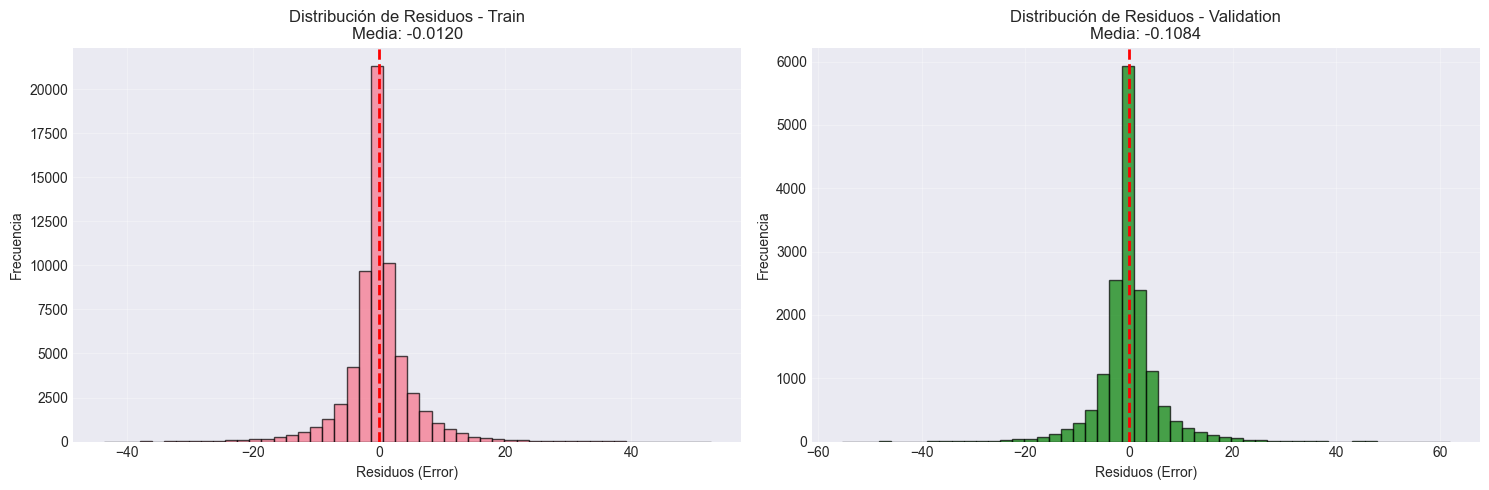

In [16]:
# Visualización 3: Distribución de residuos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

residuos_train = y_train - y_train_pred_clipped
residuos_val = y_val - y_val_pred_clipped

# Distribución de residuos - Train
axes[0].hist(residuos_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuos (Error)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Distribución de Residuos - Train\nMedia: {residuos_train.mean():.4f}')
axes[0].grid(True, alpha=0.3)

# Distribución de residuos - Validation
axes[1].hist(residuos_val, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (Error)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Residuos - Validation\nMedia: {residuos_val.mean():.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
